# Voice transformation algorithm

# Introduction

This notebook describes practical approaches to transforming voice of one to another. A goal of this notebook is to create synthetic voice that is as natural as possible.

## Table of contents
1. [User-defined library](#userdefinedlibrary)
2. [Pitch control by resampling](#pitchctrlresample)
3. [Pitch control by PSOLA algorithm](#pitchctrlpsola)
4. [Pitch & frequency stretch control by PSOLA algorithm](#pitchfreqctrlpsola)
5. [Unit tests](#unittests)

In [39]:
import numpy as np
import librosa 
from scipy.io import wavfile
from scipy import signal
import IPython.display as ipd
from copy import copy, deepcopy
import samplerate
import matplotlib.pyplot as plt

# User-defined library <a name="userdefinedlibrary"></a>

In [2]:
def butter_lowpass(cutoff: float, fs: int, order: int=3) -> tuple:
    """Find lowpass filter coefficients.
    
    Params
    ------
    cutoff: cutoff frequency in Hz
    fs: sampling frequency in Hz
    order: filter coefficient size
    
    Returns
    -------
    (b, a): numerator and denominator polynomials of the IIR filter.
    
    """
    b, a = signal.butter(order, cutoff, btype='low', fs=fs, analog=False)
    
    return (b, a)


def butter_lowpass_filter(data: np.array, cutoff: float, fs: int, order: int=3) -> np.array:
    """Apply lowpass filter to audio data to remove aliasing effect. Used for preprocessing step.
    
    Params
    ------
    data: audio data of 0.5 second length
    cutoff: cutoff frequency in Hz
    fs: sampling frequency in Hz
    order: filter coefficient size
    
    Returns
    -------
    y: lowpass filtered audio data
    """
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    
    return y


def frameize(x: np.array, N: int, H_a: int, hfilt: np.array) -> list:
    """Truncate audio sample into frames.
    
    Params
    ------
    x: audio array
    N: segment size
    H_a: analysis hop size
    hfilt: windowing filter
    
    Returns
    -------
    frames: segments of audio sample
    """
    frames = []
    idx = 0 
    
    while True:
        try: frames += [hfilt*x[H_a*idx:H_a*idx+N]]
        except: break   
        idx += 1
    
    return frames


def find_hfilt_norm(hfilt: np.array, H_s: int, delta: int=0) -> np.array:
    """Compute normalization filter array for windowing effect.
    
    Params
    ------
    hfilt: filter window used for our purpose
    H_s: synthesis hop size
    delta: small shift for synchronization
    
    Returns
    -------
    hf_norm: normalization filter array 
    """
    hf_norm = copy(hfilt)
    N = len(hfilt)
    
    if (H_s+delta) < N and (H_s+delta) >= 0:
        # add right superposed
        hf_norm[(H_s+delta):] += hfilt[:N-(H_s+delta)]
        # add left superposed
        hf_norm[:N-(H_s+delta)] += hfilt[(H_s+delta):]
        
    return hf_norm

    
def scale_time(x: np.array, N: int, H_a: int,
                 hfilt: np.array, alpha: float) -> np.array:
    """Scale time of audio sample by given ratio.
    
    Params
    ------
    x: audio data
    N: segment size
    H_a: analysis hop size
    hfilt: windowing filter
    alpha: time-scaling factor
    
    Returns
    -------
    out_x: time-scaled data 
    """
    # put into frames
    frames = frameize(x, N, H_a, hfilt)
    
    H_s = int(np.round(H_a*alpha))
    out_x = np.zeros(len(frames)*H_s+N)

    # time-scaling
    for i, frame in enumerate(frames):
        hfilt_norm = find_hfilt_norm(hfilt, H_s)    
        out_x[i*H_s:i*H_s+N] += frame/hfilt_norm

    return out_x
    

def synthesize_pitch(x: np.array, sr: int, N: int, H_a: int,
                      hfilt: np.array, alpha: float) -> np.array:
    """Synthesize sound sample into new one with different pitch using PSOLA algorithm.
    
    Params
    ------
    x: audio data
    sr: sampling rate
    N: segment size
    H_a: analysis hop size
    hfilt: windowing filter
    alpha: pitch factor
    
    Returns
    -------
    syn_x: synthesized data
    """
    syn_x = scale_time(x, N, H_a, hfilt, alpha)
    
    # apply anti-aliasing
    if alpha >= 1: syn_x = butter_lowpass_filter(syn_x, sr/2*(1/alpha)*0.6, fs=sr, order=3)

    # resampling
    syn_x = samplerate.resample(syn_x, 1/alpha, 'sinc_best')
    syn_x = syn_x/np.max(abs(syn_x))
        
    return syn_x


def warp_spectrum(S: np.array, factor: float) -> np.array:
    """Stretch frequency of spectrogram.
    
    Params
    ------
    S: spectrogram
    factor: scaling factor
    """
    out_S = np.array([np.interp((np.arange(0, len(s)) / len(s)) * factor,
                               (np.arange(0, len(s)) / len(s)),
                               s)
                      for s in S.T], dtype=complex).T
    return out_S


def shift_freq(x: np.array, alpha: float,
               n_fft=512, hop_length=64) -> np.array:
    """Scale frequency of the data.
    
    Params
    ------
    x: audio data
    alpha: scaling factor
    n_fft: FFT points
    hop_length: jump length 
    
    Returns
    -------
    syn_x: synthesized data
    """
    S1 = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
    S2 = warp_spectrum(S1, alpha**(1/3)+0.06)
    syn_x = librosa.istft(S2, hop_length=hop_length, win_length=n_fft)

    return syn_x

# Pitch control by resampling <a name="pitchctrlresample"></a>

In [3]:
import librosa 
import IPython.display as ipd

data, sr = librosa.load('example.wav', sr=None)
out_data1 = samplerate.resample(data, 0.5, 'sinc_best')
out_data2 = samplerate.resample(data, 1.5, 'sinc_best')

print('Higher pitch:')
ipd.display(ipd.Audio(out_data1, rate=sr))
print('Lower pitch:')
ipd.display(ipd.Audio(out_data2, rate=sr))

Higher pitch:


Lower pitch:


# Pitch control by PSOLA algorithm <a name="pitchctrlpsola"></a>

Higher pitch:


Lower pitch:


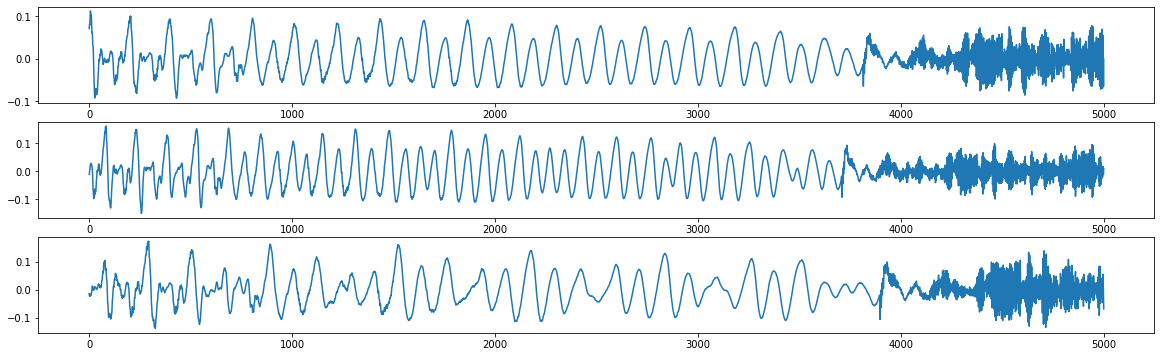

In [4]:
#make segments of 0.05-seconds (2205)
N = 1024 # segment size for sampling rate 44100 Hz
H_a = int(N*0.6) # analysis hop size between 0.5 ~ 1
hfilt = np.hanning(N) # filter type

# input 
data, sr = librosa.load('example.wav', sr=None)
ipd.display(ipd.Audio(data, rate=sr, normalize=False))

# synthesize 
out_data1 = synthesize_pitch(data, sr, N, H_a, hfilt, alpha=1.3)
out_data2 = synthesize_pitch(data, sr, N, H_a, hfilt, alpha=0.9)

# play audio
print('Higher pitch:')
ipd.display(ipd.Audio(out_data1, rate=sr, normalize=True))
print('Lower pitch:')
ipd.display(ipd.Audio(out_data2, rate=sr, normalize=True))

# plot figures
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(3, 1, 1)
ax.plot(data[50000:55000])
ax = fig.add_subplot(3, 1, 2)
ax.plot(out_data1[50000:55000])
ax = fig.add_subplot(3, 1, 3)
ax.plot(out_data2[50000:55000])

# Pitch & frequency stretch control by PSOLA algorithm

In [42]:
%%time
#make segments of 0.05-seconds (2205)
N = 1024 # segment size for sampling rate 44100 Hz
H_a = int(N*0.5) # analysis hop size between 0.5 ~ 1
hfilt = np.hanning(N) # filter type

# input 
data, sr = librosa.load('example.wav', sr=None)
ipd.display(ipd.Audio(data, rate=sr, normalize=False))
alpha = 1.3 # pitch

# pitch increase
data = synthesize_pitch(data, sr, N, H_a, hfilt, alpha=alpha)

# frequency stretching
data = shift_freq(data, alpha**(1/3)+0.06)
# X = np.fft.fft(data)
# X_hf1 = deepcopy(X[:len(X)//2+1])
# X_hf1 = np.interp((np.arange(0, len(X_hf1))/len(X_hf1))*alpha**(1/3),
#                  (np.arange(0, len(X_hf1))/len(X_hf1)), X_hf1)

# X = np.concatenate((X_hf1, np.conjugate(X_hf1[1:][::-1])))
# X[0] = np.real(X[0])
# print(len(data))
# data = np.fft.ifft(X)

ipd.display(ipd.Audio(data, rate=sr, normalize=True))

CPU times: user 359 ms, sys: 62.5 ms, total: 422 ms
Wall time: 439 ms


# Unit tests